In [18]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

In [19]:
image_size_full = 256 #256 full in 768

In [20]:
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2


class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, target_size=(image_size_full, image_size_full), augment = True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.target_size = target_size  # Target size for resizing

        self.augment = augment

        # self.augmentations = A.Compose([
        #     A.HorizontalFlip(p=0.5),
        #     A.Rotate(limit=15),
        #     A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        #     A.RandomBrightnessContrast(p=0.2),
        #     A.RandomResizedCrop(height=target_size[0], width=target_size[1], scale=(0.8, 1.0)),
        #     A.GaussianBlur(blur_limit=3, p=0.3),
        #     A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        #     A.CLAHE(clip_limit=2, p=0.3),
        #     A.Perspective(scale=(0.05, 0.1), p=0.3),
        #     A.GridDistortion(p=0.3),
        #     A.PadIfNeeded(min_height=target_size[0], min_width=target_size[1], border_mode=cv2.BORDER_REFLECT_101, p=0.3),
        # ], additional_targets={'mask': 'image'})

        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=5, p=0.5),
            A.RandomBrightnessContrast(p=0.1),
            A.GaussianBlur(blur_limit=1, p=0.1),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
            A.CLAHE(clip_limit=1, p=0.1),
        ], additional_targets={'mask': 'image'})




       
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_path, self.image_files[idx])
        mask_path = os.path.join(self.masks_path, self.mask_files[idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    # Assuming masks are also grayscale

        if self.target_size is not None:
            # Resize image and mask to target size
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) # this should help maintaining the connectivity on the mask

        if self.augment:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            
        # Normalize image to range [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Transform mask values from 0, 128, 256 to 0, 1, 2
        mask = self.transform_mask(mask)

        # Generate all coordinates and their corresponding intensities and labels
        coords_intensities, labels = self.generate_all_coordinates_intensities_and_labels(image, mask)

        return coords_intensities, labels


    def transform_mask(self, mask):
        mask_transformed = np.zeros_like(mask)
        mask_transformed[mask == 0] = 0
        mask_transformed[mask == 128] = 1
        mask_transformed[mask == 255] = 2

        return mask_transformed

    def generate_all_coordinates_intensities_and_labels(self, image, mask):
        H, W = image.shape
        
        # Create a grid of coordinates
        y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
        coords = np.stack((y_coords, x_coords), axis=-1).reshape(-1, 2)
        
        # Normalize coordinates to range [0, 1]
        coords = coords.astype(np.float32) / np.array([H, W], dtype=np.float32)
        
        # Flatten image and mask to get corresponding intensities and labels
        intensities = image.flatten()
        labels = mask.flatten()
        
        # Combine coordinates and intensities
        coords_intensities = np.hstack([coords, intensities.reshape(-1, 1)])
        
        # Convert to tensors
        coords_intensities = torch.tensor(coords_intensities, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        
        return coords_intensities, labels


In [21]:
from torch.utils.data import DataLoader

# Define paths to your image and mask directories
# images_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images' #'path/to/images'
# masks_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks' #'path/to/masks'

images_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/patch_images' #'path/to/images'
masks_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/patch_masks' #'path/to/masks'

# Create dataset and dataloader
batch_size = 4    # Adjust based on your GPU memory

dataset = SegmentationDataset(images_path, masks_path, target_size=(image_size_full, image_size_full), augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

coords_intensities, sampled_labels = next(iter(dataloader))
print(coords_intensities.shape, sampled_labels.shape)

torch.Size([4, 65536, 3]) torch.Size([4, 65536])


c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


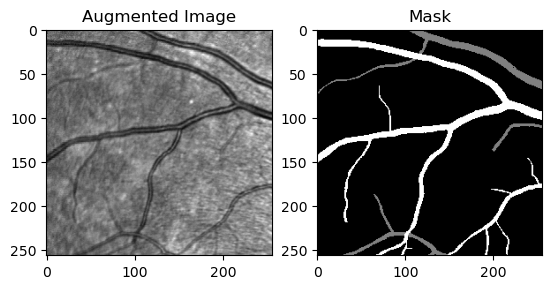

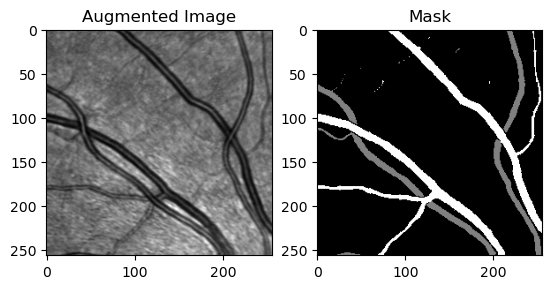

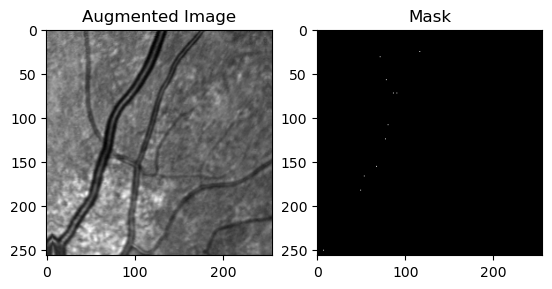

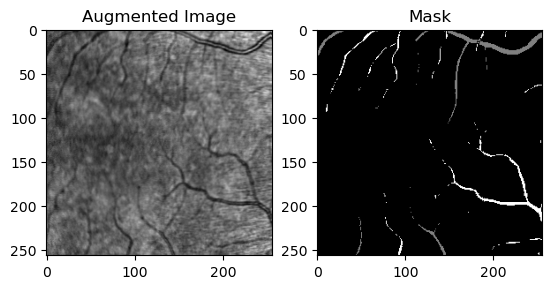

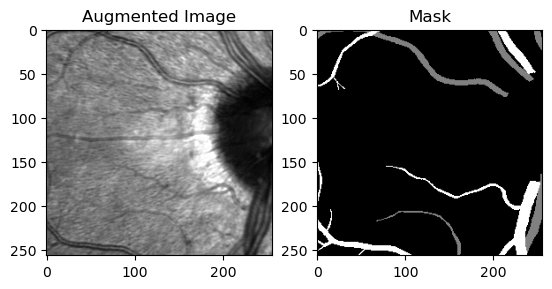

In [22]:
import matplotlib.pyplot as plt

def show_augmented_images(dataset, num_images=5):
    for i in range(num_images):
        coords_intensities, labels = dataset[i]
        image = coords_intensities[:, 2].reshape(dataset.target_size)
        mask = labels.reshape(dataset.target_size)
        
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Augmented Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Mask')
        plt.show()

# Visualizza alcune immagini augmentate
show_augmented_images(dataset)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies
        x = x.unsqueeze(-1) * frequencies.unsqueeze(0).unsqueeze(0)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        return x.view(x.shape[0], -1)
    
class AdaptiveDropout(nn.Module):
    def __init__(self, initial_p=0.5, decay_factor=0.95):
        super(AdaptiveDropout, self).__init__()
        self.p = initial_p
        self.decay_factor = decay_factor

    def forward(self, x):
        if self.training:
            return F.dropout(x, p=self.p, training=True)
        else:
            return x

    def step(self):
        self.p *= self.decay_factor  # Decrement dropout probability
    
# Sine Layer
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super(SineLayer, self).__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.omega_0 * x)
        return x

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes, hidden_dim=image_size_full, num_layers=5, num_freqs=10, initial_dropout_p=0.5, outermost_linear=False):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)
        self.mlp = nn.ModuleList()
        input_dim = num_freqs * 2 * 2 + 1  # 2 for (x, y) and 2 for sin/cos, 1 for intensity

        # self.mlp.append(nn.Linear(input_dim, hidden_dim))
        # self.mlp.append(SineLayer(hidden_dim, hidden_dim))

        # Adding AdaptiveDropout
        self.dropouts = nn.ModuleList([AdaptiveDropout(initial_dropout_p) for _ in range(num_layers - 1)])

        self.mlp.append(nn.Sequential(
            # nn.Linear(input_dim, hidden_dim),
            SineLayer(in_features=input_dim, out_features=hidden_dim, is_first=True),
            nn.BatchNorm1d(hidden_dim*hidden_dim),
            self.dropouts[0]
        ))

        for i in range(1, num_layers - 2):
            # self.mlp.append(nn.Linear(hidden_dim, hidden_dim))
            # self.mlp.append(SineLayer(hidden_dim, hidden_dim)) --> activation -1 +1 
            self.mlp.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim*hidden_dim),
                self.dropouts[i]
            ))

        if outermost_linear:
            self.mlp.append(nn.Linear(hidden_dim, num_classes))
        else:
            self.mlp.append(SineLayer(in_features=hidden_dim, out_features=num_classes, is_first=False))

    def forward(self, coords_intensities):
        bs, ns, _ = coords_intensities.size()
        coords, intensities = coords_intensities[:, :, :-1], coords_intensities[:, :, -1].view((bs, ns,1))
        x = self.pos_enc(coords).view((bs, ns, -1))
        x = torch.cat([x, intensities], dim=-1)
        # print("Shape before first MLP:", x.shape)
        for layer in self.mlp[:-1]:
            x = layer(x)
            # print("Current shape in loop:", x.shape)
        x = self.mlp[-1](x)
        return x # Return logits without activation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [24]:
# import torch.nn.functional as F

# class MultiClassDiceLoss(nn.Module):
#     def __init__(self, num_classes, smooth=1):
#         super(MultiClassDiceLoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, inputs, targets):
#         # Convert class indices to one-hot encoding
#         targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
#         # Apply softmax to get probabilities
#         inputs = F.softmax(inputs, dim=1)
        
#         # Flatten the inputs and targets for each class
#         inputs = inputs.view(-1, self.num_classes)
#         targets_one_hot = targets_one_hot.view(-1, self.num_classes)
        
#         # Compute the intersection and union for each class
#         intersection = (inputs * targets_one_hot).sum(dim=0)
#         union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
#         # Compute the Dice coefficient for each class
#         dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
#         # Average Dice coefficient across classes
#         dice_loss = 1 - dice.mean()
        
#         return dice_loss

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalDiceLoss(nn.Module):
    def __init__(self, num_classes=3, gamma=2, alpha=0.25, smooth=1):
        """
        Combina Dice Loss e Focal Loss per gestire lo sbilanciamento tra le classi.
        :param num_classes: Numero di classi
        :param gamma: Parametro di Focal Loss per ridurre l'impatto delle classi maggioritarie
        :param alpha: Peso per le classi minoritarie in Focal Loss
        :param smooth: Fattore per evitare divisioni per zero nella Dice Loss
        """
        super(FocalDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.alpha = alpha
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert class indices to one-hot encoding
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
        # Apply softmax to get probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Flatten the inputs and targets for each class
        inputs_flat = inputs.view(-1, self.num_classes)
        targets_flat = targets_one_hot.view(-1, self.num_classes)
        
        # Compute the intersection and union for Dice Loss
        intersection = (inputs_flat * targets_flat).sum(dim=0)
        union = inputs_flat.sum(dim=0) + targets_flat.sum(dim=0)
        
        # Compute Dice coefficient for each class
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()
        
        # Compute Focal Loss
        logpt = -F.cross_entropy(inputs, targets, reduction='none') # log probability
        pt = torch.exp(logpt)  # Convert log probabilities to probabilities
        focal_loss = ((1 - pt) ** self.gamma) * logpt
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        
        focal_loss = focal_loss.mean()

        # Combine Dice Loss and Focal Loss
        total_loss = dice_loss + focal_loss
        
        return total_loss

In [26]:
# Define your model
num_classes = 3 
num_layers = 7
hidden_dim = image_size_full
outer_layer_linear = True
num_freq = 10

In [27]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim

model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers, outermost_linear=outer_layer_linear, num_freqs=num_freq).to(device)

# Use AdamW optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# Define your loss function
# criterion = MultiClassDiceLoss(num_classes) # nn.CrossEntropyLoss()
criterion = FocalDiceLoss(num_classes=num_classes)

# Define the cosine annealing learning rate scheduler
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=30, verbose=True)


num_epochs = 1000

losses = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # To store the loss of each epoch
    for batch in dataloader:
        coords_intensities, labels = batch
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(coords_intensities)
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    # Step the scheduler
    scheduler.step(epoch_loss)

    if epoch == 0 or (epoch+ 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/1000], Loss: 0.6545
Epoch [50/1000], Loss: 0.5751
Epoch [100/1000], Loss: 0.5440
Epoch [150/1000], Loss: 0.5483
Epoch [200/1000], Loss: 0.5305
Epoch [250/1000], Loss: 0.5299
Epoch [300/1000], Loss: 0.5311
Epoch [350/1000], Loss: 0.5230
Epoch [400/1000], Loss: 0.5330
Epoch [450/1000], Loss: 0.5312
Epoch [500/1000], Loss: 0.5283
Epoch [550/1000], Loss: 0.5268
Epoch [600/1000], Loss: 0.5251
Epoch [650/1000], Loss: 0.5318
Epoch [700/1000], Loss: 0.5210
Epoch [750/1000], Loss: 0.5292
Epoch [800/1000], Loss: 0.5353
Epoch [850/1000], Loss: 0.5322
Epoch [900/1000], Loss: 0.5395
Epoch [950/1000], Loss: 0.5286
Epoch [1000/1000], Loss: 0.5360


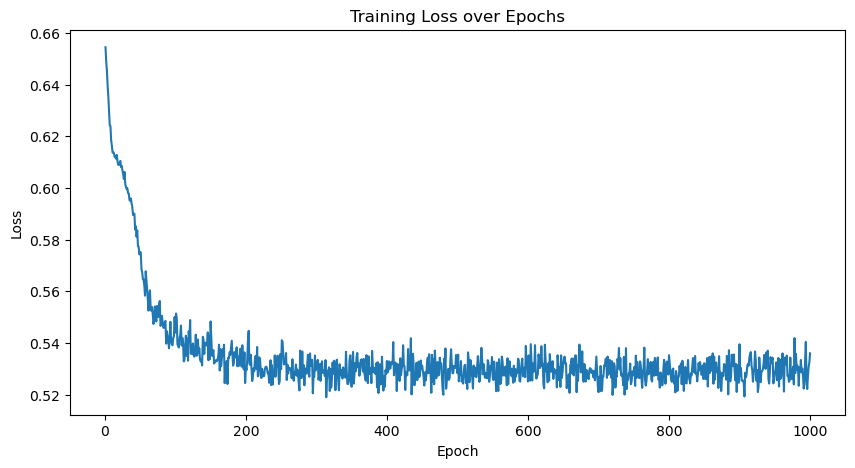

In [28]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [29]:
name_of_model = 'retina_segmentation_model_with_patch_1.pth'

In [30]:
torch.save(model.state_dict(), name_of_model)

In [31]:
test_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/test'


In [32]:
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define your model
num_classes = 3 

# Define your loss function
# criterion = MultiClassDiceLoss(num_classes) # nn.CrossEntropyLoss()
criterion = FocalDiceLoss(num_classes=num_classes)

# Assumi che Siren sia già definito altrove nel codice
model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers, outermost_linear=outer_layer_linear, num_freqs=num_freq).to(device)
model.load_state_dict(torch.load(name_of_model))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def visualize_segmentation_mask(mask, title):
    """
    Visualizes the segmentation mask using Matplotlib.
    
    Args:
    mask (numpy.ndarray): 2D array of shape (H, W) with values 0, 1, or 2
    """
    # Define color mapping
    color_mapping = {
        0: [255, 255, 255], # White
        1: [0, 0, 255],     # Blue
        2: [255, 0, 0]      # Red
    }

    # Create an RGB image from the mask
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_value, color in color_mapping.items():
        rgb_image[mask == class_value] = color

    # Normalize the RGB values to the range [0, 1] for matplotlib
    rgb_image = rgb_image / 255.0

    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide the axes
    plt.title(title)

def evaluate_model(model, coords_intensities, labels, img_size):
    model.eval()  # Set model to evaluation mode
    
    coords_intensities, labels = coords_intensities.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(coords_intensities.unsqueeze(0))

        print(outputs)
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))

        predicted_mask = outputs.argmax(dim=-1).view(img_size).cpu().numpy()
        print(predicted_mask)

    # Plot the ground truth and predicted masks side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    visualize_segmentation_mask(labels.view(img_size).cpu().numpy(), title="Ground Truth")

    plt.subplot(1, 2, 2)
    visualize_segmentation_mask(predicted_mask, title=f"Predicted Mask (DiceLoss = {loss.item():.3f})")
    
    plt.show()

C:\Users\Q540900\AppData\Local\Temp\ipykernel_18056\2030443685.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(name_of_model))


tensor([[[ 1.2611e+01, -3.9970e+00, -7.8709e+00],
         [ 6.9563e+00, -4.8247e-03, -6.6341e+00],
         [ 6.6888e+00,  2.3693e-05, -6.3996e+00],
         ...,
         [ 1.2243e+01, -3.8746e+00, -7.6563e+00],
         [ 1.2510e+01, -4.1112e+00, -7.6478e+00],
         [ 1.4172e+01, -5.1689e+00, -8.1555e+00]]], device='cuda:0')
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


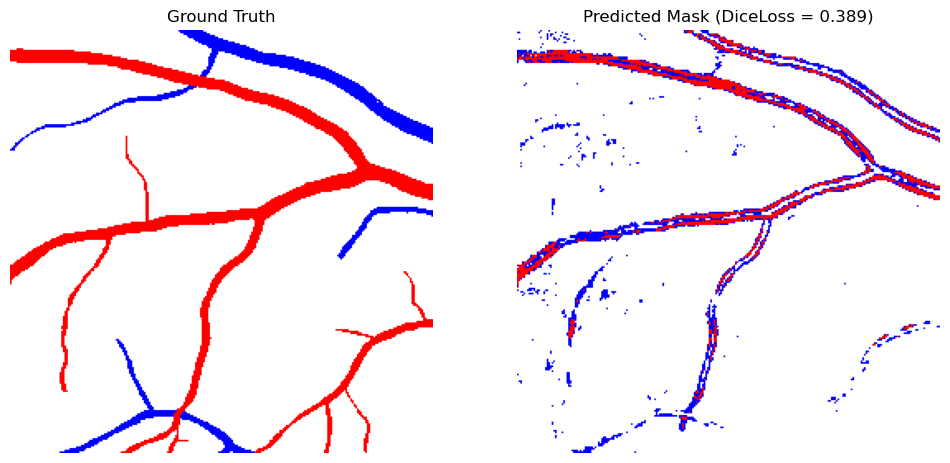

In [33]:
dataset2 = SegmentationDataset(images_path, masks_path, target_size=(image_size_full, image_size_full), augment=False)
eg_img, eg_mask = dataset2[0]
evaluate_model(model, eg_img, eg_mask, img_size=(image_size_full, image_size_full))

1) not include the sinelayer everytime
2) plays with the scheduler --> avoid local minima
3) not normalize --> avoid smooth convergence 
4) add augmentation techniques 
5) different retina dataset --> https://paperswithcode.com/dataset/hrf

meeting on 05.07

1. CrossEntropy or DiceLoss or FocalLoss

In [34]:
# 10 patch per images
# dice loss 0.365 --> 6 layer,outer layer true, augmentation yes, num_freq = 10
# dice loss 0.349 --> 3 layer, outer layer true, augmentation yes, num_freq = 10
# dice loss 0.365 --> 3 layer, outer layer true, augmentation false, num_freq = 10
# dice loss 0. --> 10 layer, outer layer true, augmentation false, num_freq = 10


# dice loss 0.397 --> 3 layer, outer layer true, augmentation yes, num_freq = 10
# dice loss  0.369 --> 3 layer, outer layer true, augmentation false, num_freq = 10

# 30 patches per image
# dice loss  0.535 --> 3 layer, outer layer false, augmentation false, num_freq = 10
# dice loss  0.534 --> 3 layer, outer layer false, augmentation false, num_freq = 5
# dice loss  0.535 --> 3 layer, outer layer false, augmentation false, num_freq = 25

# dice loss 0.356  --> 3 layer, outer layer True, augmentation false, num_freq = 25

# dice loss 0.363  --> 5 layer, outer layer True, augmentation false, num_freq = 25

# dice loss  0.353 --> 7 layer, outer layer true, augmentation false, num_freq = 10
# dice loss  0.389 --> 7 layer, outer layer true, augmentation true, num_freq = 10
